In [11]:
import numpy as np
import os
from keras import backend as K
import pandas as pd

Using TensorFlow backend.


#### import reco files

define paths of reco numu and nue files

In [5]:
from data_loaders import get_n_iterations, metadata_generator, data_generator

In [6]:
from tqdm import tqdm

In [7]:
n_files=100
batch_size=64

In [12]:
directory_reco = "/data/km3net/extracted_trees_reco_files"
reco_files_numu = [os.path.join(directory_reco, "km3_v4_numuCC_{}.evt.JEnergy.rootreco_trees.npz".format(i+1)) 
                   for i in range(100)]
reco_files_nue = [os.path.join(directory_reco, "km3_v4_nueCC_{}.evt.JEnergy.rootreco_trees.npz".format(i+1))
                  for i in range(100)]

#### import doms_map files

import doms map files to select numu and nue files with more than 5 doms hit

In [13]:
doms_map_files_numu = ["/data/km3net/Xy_multi_data_files/numu_{}_sel5_doms_map.npz".format(i+1) for i in range(100)] 
doms_map_files_nue = ["/data/km3net/Xy_multi_data_files/nue_{}_sel_5_doms_map.npz".format(i+1) for i in range(100)]    

In [4]:
## Cross Check 
for i in range(100):
    numu_file, numu_map = np.load(reco_files_numu[i])['dirz'], np.load(doms_map_files_numu[i])['id']
    nue_file, nue_map = np.load(reco_files_nue[i])['dirz'], np.load(doms_map_files_nue[i])['id']
    if numu_file.shape != numu_map.shape or nue_file.shape != nue_map.shape: 
        print('WRONG ', i+1)
        print('NUMU: ', numu_file.shape, numu_map.shape)
        print('NUE: ', nue_file.shape, nue_map.shape)
print("Cross-check completed!!")

Cross-check completed!!


#### import indices files and indices of test events

import indices to select test files

In [5]:
index_files = ["train_test_files/Xy_indx{}_sel5_doms.npz".format(i+1) for i in range(100)]
test_indices = [np.load(index_files[i])["test"] for i in range(100)]

In [6]:
## Cross Check
for i in range(100):
    numu = np.load(doms_map_files_numu[i])['id']
    numu = numu[numu==True]
    nue = np.load(doms_map_files_nue[i])['id']
    nue = nue[nue==True]
    tot_evts = numu.shape[0] + nue.shape[0]
    assert np.all(np.isin(test_indices[i], np.arange(tot_evts)) == True)
print('Cross-check completed!!')

Cross-check completed!!


#### function to select reco events with more than 5 doms

definition of the function

In [4]:
def sel_doms_arr(data_filepath, map_filepath, target_key):
    """Selects all events with more than 5 doms hits - according to the input doms_map"""
    with np.load(data_filepath) as data_file, np.load(map_filepath) as map_file:
        return data_file[target_key][map_file["id"]]

## CosZ

select reco files (dirz) and stack numu+nue

In [11]:
nu_stack_dirz = [np.hstack((sel_doms_arr(reco_files_numu[i], doms_map_files_numu[i], "dirz"),
                            sel_doms_arr(reco_files_nue[i], doms_map_files_nue[i], "dirz"))) for i in range(100)]

In [12]:
## Double cross check
for i in range(100):
    assert np.all(test_indices[i] < nu_stack_dirz[i].shape[0])

#### selecting cosz of reco files corresponding to y_test dir_z

In [13]:
y_reco = np.hstack(nu_stack_dirz[i][test_indices[i]] for i in range(100))
print(y_reco.shape)

(51818,)


In [16]:
np.savetxt("cos_z_reco.txt", y_reco)

define paths and filenames

In [17]:
train_test_dir = os.path.abspath("/data/km3net/Xy_multi_data_files/train_test_files/cosz_no_stratify")
fnames_test =[os.path.join(train_test_dir, "Xy_test{}_sel5_doms.npz".format(i+1)) for i in range(100)]
index_filelist = [os.path.join(train_test_dir, "Xy_indx{}_sel5_doms.npz".format(i+1)) for i in range(100)]

dir_xy = os.path.join("/", "data", "km3net", "Xy_multi_data_files")
xy_filelist = [(os.path.join(dir_xy, "Xy_numu_{}_multi_data.npz".format(i+1)), 
                os.path.join(dir_xy, "Xy_nue_{}_multi_data.npz".format(i+1))) for i in range(100)]
metadata_keylist = ["E", "dirx", "diry", "dirz", "posx","posy","posz", "dist"]

In [18]:
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], batch_size=64)
print(predict_steps, n_test_events)

(810, 51818)


import metadata

In [19]:
y_true = list()
metadata = None
metadata_gen  = metadata_generator(index_filelist, xy_filelist, metadata_keylist)
data_gen = data_generator(fnames_test[:n_files], batch_size=batch_size, 
                          ftarget=lambda y: y)

for i in tqdm(range(predict_steps)):
    _, y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))
    y_true.append(y_batch_true)
    
y_true = np.hstack(np.asarray(y_true))

100%|██████████| 810/810 [00:39<00:00, 20.34it/s]


In [20]:
## Cross Check on true labels
y_true_md = metadata["dirz"]
np.all(y_true==y_true_md)

True

## Reconstruction Error for CosZ

In [22]:
from sklearn.metrics import mean_squared_error, r2_score

In [23]:
mean_squared_error(y_true, y_reco)

0.105795228522975

In [24]:
r2_score(y_true, y_reco)

0.66967778192396121

In [25]:
indx_pos = np.where(y_true>0)[0]
indx_zero = np.where(y_true==0)[0]
indx_neg = np.where(y_true<0)[0]

In [26]:
indx_pos.shape, indx_zero.shape, indx_neg.shape

((28122,), (0,), (23696,))

In [27]:
indx_reco_pos = np.where(y_reco>0)[0]
indx_reco_zero = np.where(y_reco==0)[0]
indx_reco_neg = np.where(y_reco<0)[0]

indx_reco_pos.shape, indx_reco_zero.shape, indx_reco_neg.shape

((29032,), (705,), (22081,))

In [28]:
mse_up = mean_squared_error(y_true[indx_pos], y_reco[indx_pos])
mse_dwn = mean_squared_error(y_true[indx_neg], y_reco[indx_neg])

In [29]:
mse_up, mse_dwn

(0.087028283101569084, 0.12806751241649192)

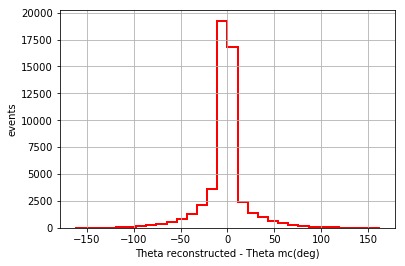

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(np.degrees(np.arccos(y_reco))-np.degrees(np.arccos(y_true)), label="reco_evts", 
         bins=30, histtype="step", color="red",lw=2)
#plt.hist(np.degrees(np.arccos(y_true)), alpha=0.5, label="mc_evts")
plt.grid()
plt.xlabel("Theta reconstructed - Theta mc(deg)")
plt.ylabel("events")
#plt.legend(loc="upper right")

### check updown prediction (RECO) using labels on cosz (cosz>0 : 1 , cosz<=0: 0) 

In [31]:
def process_cosz(y):
    y_p = np.copy(y)
    y_p[y_p>0] = 1
    y_p[y_p<=0] = 0
    return y_p 

y_true_label = list()
metadata_label = None
metadata_gen  = metadata_generator(index_filelist, xy_filelist, metadata_keylist)
data_gen = data_generator(fnames_test[:n_files], batch_size=batch_size, 
                          ftarget = process_cosz) #ftarget=lambda y: y)

for i in tqdm(range(predict_steps)):
    _, y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata_label is None:
        metadata_label = metadata_batch
    else:
        metadata_label = pd.concat((metadata_label, metadata_batch))
    y_true_label.append(y_batch_true)
    
y_true_label = np.hstack(np.asarray(y_true_label))

In [33]:
# Apply transformation to predicted cosz by reconstruction algo
y_reco_label = process_cosz(y_reco)

In [34]:
y_true_label

array([ 1.,  0.,  1., ...,  1.,  0.,  1.])

In [35]:
y_reco_label

array([ 1.,  0.,  1., ...,  1.,  0.,  1.])

In [36]:
y_reco

array([ 0.37781371, -0.92092376,  0.29512669, ...,  0.52920841,
       -0.20345487,  0.75998886])

In [37]:
from sklearn.metrics import accuracy_score

In [38]:
accuracy_score(y_true_label, y_reco_label)

0.89698560345825773

In [39]:
from sklearn.metrics import confusion_matrix

In [40]:
confusion_matrix(y_true_label, y_reco_label)

array([[20572,  3124],
       [ 2214, 25908]])

#### calculate mse as a function of Energy

In [43]:
y_true_md_E = metadata["E"]

In [17]:
nu_stack_E = [np.hstack((sel_doms_arr(reco_files_numu[i], doms_map_files_numu[i], "E"),
                            sel_doms_arr(reco_files_nue[i], doms_map_files_nue[i], "E"))) for i in range(100)]
for i in range(100):
    assert np.all(test_indices[i] < nu_stack_E[i].shape[0])

y_reco_E = np.hstack(nu_stack_E[i][test_indices[i]] for i in range(100))
print(y_reco_E.shape)

(51818,)


In [18]:
y_reco_E

array([  3885.96330439,   1584.14626589,   9711.8879869 , ...,
        50497.28018932,    133.13961295,  12900.60646196])

In [20]:
np.savetxt("reco_E.txt", y_reco_E)

/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:1: RuntimeWarning: divide by zero encountered in log10
  """Entry point for launching an IPython kernel.


array([ 3.5894987 ,  3.19979528,  3.98730366, ...,  4.70326799,
        2.12430729,  4.11061013])

In [46]:
np.asarray(y_true_md_E)

array([   736.304,   2120.99 ,  12032.7  , ...,  32068.7  ,    417.957,
        18014.5  ])

In [47]:
mean_squared_error(y_true_md_E, y_reco_E)

9.7385828650566746e+19

### WTF????

In [48]:
%matplotlib inline

In [49]:
metadata["E"].describe()

count    5.181800e+04
mean     7.457190e+05
std      4.701909e+06
min      5.411270e-02
25%      1.416680e+03
50%      6.431605e+03
75%      5.173847e+04
max      9.298330e+07
Name: E, dtype: float64

In [51]:
min_E = np.min(y_true_md_E)
max_E = np.max(y_true_md_E)

In [53]:
print("min mc E: {:e}, max mc E: {:e}".format(np.min(y_true_md_E), np.max(y_true_md_E)))

min mc E: 5.411270e-02, max mc E: 9.298330e+07


In [54]:
y_true_E = np.asarray(y_true_md_E)

In [55]:
y_true_E[y_true_E<1e4].shape

(29335,)

In [56]:
y_true_E[y_true_E>1e4].shape

(22483,)

In [57]:
low_E_indx = np.where(y_true_E<1e4)[0]
high_E_indx = np.where(y_true_E>1e4)[0]

In [58]:
low_E_indx

array([    0,     1,     4, ..., 51813, 51814, 51816])

In [59]:
high_E_indx

array([    2,     3,     5, ..., 51812, 51815, 51817])

In [60]:
y_true_E[low_E_indx]

array([  736.304,  2120.99 ,  6110.15 , ...,   362.679,  2954.27 ,
         417.957])

In [61]:
print("min reco E: {:3}, max reco E: {:e}".format(np.min(y_reco_E),np.max(y_reco_E)))

min reco E: 0.0, max reco E: 1.550397e+12


In [62]:
import matplotlib.pyplot as plt

In [63]:
y_reco_E[y_reco_E<1e4].shape

(28749,)

In [64]:
y_reco_E[y_reco_E>1e4].shape

(23069,)

In [65]:
mse_lowE = mean_squared_error(y_true[low_E_indx], y_reco[low_E_indx])
mse_highE = mean_squared_error(y_true[high_E_indx], y_reco[high_E_indx])

In [66]:
print(mse_lowE,mse_highE )

(0.069854939165106752, 0.15268880982053606)


### energy binning

In [67]:
def energy_maps(energies, nbins = 2):
    
    log_energies = np.log10(energies)
    
    E_maps = []
    binned, energy_bins = np.histogram(log_energies,bins=nbins)#, 
                                  #range=(log_energies.min(), log_energies.max()))

    for i, E in enumerate(zip(energy_bins[:-1], energy_bins[1:])):
        lowE, highE = E
        E_maps.append((i, np.where(np.logical_and(log_energies>=lowE, log_energies<highE))[0]))
    return E_maps

In [68]:
E_maps = energy_maps(y_true_E)

In [69]:
log_E = np.log10(y_true_md_E.as_matrix())

In [70]:
min_E = np.min(log_E)
max_E = np.max(log_E)
bin_edges = np.array([min_E, 1.0, 2.8, 3.5, 4.0, 7.0, max_E])

In [71]:
dg_maps = np.digitize(log_E, bin_edges)

In [72]:
np.unique(dg_maps)

array([1, 2, 3, 4, 5, 6, 7])

In [73]:
log_E[np.where(dg_maps==7)[0]]

array([ 7.96840496])

In [74]:
for i in range(len(E_maps)):
    print("mse: {}, n_evts: {}".format(mean_squared_error(y_true[E_maps[i][1]], y_reco[E_maps[i][1]]), 
                                       E_maps[i][1].shape))

mse: 0.0703385625816, n_evts: (17041,)
mse: 0.123172811897, n_evts: (34776,)


### apply energy correction

In [75]:
y_reco_E

array([  3885.96330439,   1584.14626589,   9711.8879869 , ...,
        50497.28018932,    133.13961295,  12900.60646196])

In [76]:
def correct_energy(x):
     return ((((((x<=1.0)*x)+(((x>1.0)and(x<=2.8))*(-(7.20045)+(x*3.01))))+(((x>2.8)and(x<=3.5))*(1081.22+(x*(-(1336.46)+(x*(614.871+(x*(-(124.755)+(x*9.43893))))))))))+(((x>3.5)and(x<=4.0))*(-(60.3619)+(x*(45.7012+(x*(-(11.0884)+(x*0.923034))))))))+(((x>4.0)and(x<7.0))*(-(8.72485)+(x*(5.16495+(x*(-(0.174627)+(x*(-(0.198979)+(x*(0.0385912+(x*-(0.00213019)))))))))))))+((x>7.0)*(0.375618+(x*1.01931)))

In [77]:
v_correct_energy = np.vectorize(correct_energy)

In [82]:
nonz = np.nonzero(y_reco_E)[0]

In [83]:
v_correct_energy(np.log10(y_reco_E[nonz]))

array([ 3.50330452,  2.59804605,  4.08617161, ...,  4.98390898,
       -0.80628506,  4.25319267])

In [84]:
y_reco_E[0]

3885.9633043897002

In [85]:
correct_energy(np.log10(y_reco_E[0]))

3.5033045183205473

In [86]:
np.log10(metadata['E'].as_matrix()[0])

2.867057159804705

In [87]:
mean_squared_error(np.log10(metadata["E"].as_matrix()[nonz]), np.log10(y_reco_E[nonz]))

1.3257663051118915

In [88]:
true_e =np.log10(metadata["E"].as_matrix()[nonz])

In [89]:
reco_corrected_e = v_correct_energy(np.log10(y_reco_E[nonz]))

In [90]:
true_e[:10]

array([ 2.86705716,  3.32653862,  4.08036309,  4.69319034,  3.78605187,
        4.01650686,  2.28024137,  3.28830513,  3.32635225,  3.77277044])

In [91]:
reco_corrected_e[:10]

array([ 3.50330452,  2.59804605,  4.08617161,  4.94347958,  2.81572848,
        0.76144695,  4.20064701,  1.74238386,  2.6536576 ,  3.83245249])

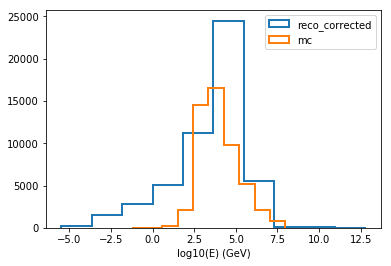

In [92]:
plt.hist(reco_corrected_e, label="reco_corrected", histtype="step", lw=2)
plt.hist(true_e, label = "mc", histtype="step", lw=2)
plt.xlabel("log10(E) (GeV)")
plt.legend(loc="upper right")
#plt.hist(y_reco_E[nonz], alpha=0.5)

# Reconstruction Performances

## CosZ Estimation

In [76]:
# PATH UNISA: "aafiles/Jpp_v6_aa_files/Xy_multi_data_files/extracted_trees_reco_files/"
directory_reco = '/data/km3net/extracted_trees_reco_files/'

In [77]:
from data_files import get_multi_data_files, get_reco_files, get_train_validation_test_files, get_doms_maps

In [78]:
n_files=100
batch_size=64

In [79]:
# PATH UNISA: "aafiles/Jpp_v6_aa_files/Xy_multi_data_files/"
doms_map_dir = '/data/km3net/Xy_multi_data_files/'
doms_map_files = get_doms_maps(doms_map_dir)

In [80]:
reco_files_numu = get_reco_files(directory_reco)

In [81]:
# PATH UNISA: "train_test_files/cosz"
train_test_dir = '/data/km3net/Xy_multi_data_files/train_test_files/cosz_no_stratify/'
_, _, test_filelist, index_filelist = get_train_validation_test_files(train_test_dir)

In [82]:
# PATH UNISA: "aafiles/Jpp_v6_aa_files/Xy_multi_data_files/"
multi_data_dir = '/data/km3net/Xy_multi_data_files/'
multi_data = get_multi_data_files(multi_data_dir)

In [83]:
from data_loaders import metadata_generator, data_generator

In [84]:
from tqdm import tqdm

In [85]:
metadata_keylist = ["E", "dirx", "diry", "dirz", "posx","posy","posz", "dist"]

In [86]:
xy_filelist = multi_data
fnames_test = test_filelist

In [87]:
from data_loaders import get_n_iterations

In [88]:
predict_steps, n_test_events = get_n_iterations(fnames_test[:n_files], batch_size=64)
print(predict_steps, n_test_events)

(810, 51818)


### get test files metadata

In [89]:
y_true = list()
metadata = None
metadata_gen  = metadata_generator(index_filelist, xy_filelist, metadata_keylist)
data_gen = data_generator(fnames_test[:n_files], batch_size=batch_size, 
                          ftarget=lambda y: y)

for i in tqdm(range(predict_steps)):
    _, y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))
    y_true.append(y_batch_true)
    
y_true = np.hstack(np.asarray(y_true))

100%|██████████| 810/810 [00:38<00:00, 20.99it/s]


In [90]:
multi_data_numu, _ = get_multi_data_files("/data/km3net/Xy_multi_data_files/", merge=False)

In [91]:
metadata.columns

Index([u'E', u'dirx', u'diry', u'dirz', u'posx', u'posy', u'posz', u'dist',
       u'file_evt_index', u'evt_index'],
      dtype='object')

### load dir_z from test files selecting only numu events

In [92]:
y_true_dirz_numu = []
test_indices_numu=[]

for i in range(100):
    length = len(np.load(multi_data_numu[i])["y"])
    test_indx = np.load(index_filelist[i])["test"]

    y_true_dirz_numu.append(np.asarray(metadata[(metadata["file_evt_index"]==i) &
                                                (metadata["evt_index"]<length)]["dirz"]))

    test_indices_numu.append(test_indx[test_indx<length])

In [93]:
y_true_dirz_numu = np.hstack(y_true_dirz_numu)

In [94]:
y_true_dirz_numu.shape

(30469,)

In [95]:
np.savetxt("cosz_numu_true.txt", y_true_dirz_numu)

### import reco dir_z

In [96]:
def sel_doms_arr(data_filepath, map_filepath, target_key):
    """Selects all events with more than 5 doms hits - according to the input doms_map"""
    with np.load(data_filepath) as data_file, np.load(map_filepath) as map_file:
        return data_file[target_key][map_file["id"]]

In [97]:
reco_nu_stack_dirz = [np.hstack(sel_doms_arr(reco_files_numu[0][i], doms_map_files[0][i], "dirz")) for i in range(100)]


In [98]:
y_reco_dirz = np.hstack(reco_nu_stack_dirz[i][test_indices_numu[i]] for i in range(100))
print(y_reco_dirz.shape)

(30469,)


In [99]:
np.savetxt("cosz_numu_reco.txt", y_reco_dirz)

In [100]:
from sklearn.metrics import mean_squared_error, r2_score

In [101]:
mean_squared_error(y_true_dirz_numu, y_reco_dirz)

0.034132191771554889

In [102]:
r2_score(y_true_dirz_numu, y_reco_dirz)

0.88793227612926673

### Up/Down Accuracy on Reco

In [74]:
y_reco_numu_updown = process_cosz(y_reco_dirz)

In [75]:
y_reco_updown[:10]

array([ 0.,  1.,  0.,  0.,  1.,  0.,  1.,  1.,  1.,  1.])

In [76]:
y_true_numu_updown = process_cosz(y_true_dirz_numu)

In [77]:
accuracy_score(y_true_numu_updown, y_reco_numu_updown)

0.96504644064458955

In [78]:
confusion_matrix(y_true_numu_updown, y_reco_numu_updown)

array([[12673,   512],
       [  553, 16731]])

##  Energy Estimation

In [7]:
def sel_doms_arr(data_filepath, map_filepath, target_key):
    """Selects all events with more than 5 doms hits - according to the input doms_map"""
    with np.load(data_filepath) as data_file, np.load(map_filepath) as map_file:
        return data_file[target_key][map_file["id"]]

In [8]:
from data_files import get_multi_data_files, get_reco_files, get_train_validation_test_files, get_doms_maps
from tqdm import tqdm

In [9]:
n_files=100
batch_size=64

In [10]:
# PATH UNISA: "aafiles/Jpp_v6_aa_files/Xy_multi_data_files/"
doms_map_dir = '/data/km3net/Xy_multi_data_files/'
doms_map_files = get_doms_maps(doms_map_dir)

In [11]:
directory_reco = '/data/km3net/extracted_trees_reco_files/'
reco_files_numu = get_reco_files(directory_reco)

In [12]:
train_test_dir = '/data/km3net/Xy_multi_data_files/train_test_files/cosz_no_stratify/'
_, _, test_filelist, index_filelist = get_train_validation_test_files(train_test_dir)

In [13]:
multi_data_files = get_multi_data_files('/data/km3net/Xy_multi_data_files/', merge=True)

In [14]:
from data_loaders import metadata_generator, data_generator, get_n_iterations

In [15]:
predict_steps, n_test_events = get_n_iterations(test_filelist[:n_files], batch_size=64)
print(predict_steps, n_test_events)

(810, 51818)


In [16]:
metadata_keylist = ["E", "dirx", "diry", "dirz", "posx","posy","posz", "dist"]

metadata = None
metadata_gen  = metadata_generator(index_filelist, multi_data_files, metadata_keylist, index_key='test')

for i in tqdm(range(predict_steps)):
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))

100%|██████████| 810/810 [00:01<00:00, 466.63it/s]


In [17]:
numu_files, _ = get_multi_data_files('/data/km3net/Xy_multi_data_files/', merge=False)

In [46]:
y_true_E_numu = []
test_indices_numu=[]
test_indices_numu_pred=[]
for i in range(100):
    length = len(np.load(numu_files[i])["y"])
    test_indx = np.load(index_filelist[i])["test"]
    y_true_E_numu.append(metadata[(metadata["file_evt_index"]==i) & (metadata["evt_index"]<length)]["E"])
    test_indices_numu.append(test_indx[test_indx<length])
    test_indices_numu_pred.append(np.where(test_indx < length)[0])
y_true_E_numu = np.hstack(y_true_E_numu)

In [47]:
y_true_E_numu.shape

(30469,)

In [48]:
y_reco_nu_stack_E = [np.hstack(sel_doms_arr(reco_files_numu[0][i], doms_map_files[0][i], "E")) for i in range(100)]


In [49]:
y_reco_numu_E = np.hstack(y_reco_nu_stack_E[i][test_indices_numu[i]] for i in range(100))
print(y_reco_numu_E.shape)

(30469,)


In [50]:
def correct_energy(x):
     return ((((((x<=1.0)*x)+(((x>1.0)and(x<=2.8))*(-(7.20045)+(x*3.01))))+(((x>2.8)and(x<=3.5))*(1081.22+(x*(-(1336.46)+(x*(614.871+(x*(-(124.755)+(x*9.43893))))))))))+(((x>3.5)and(x<=4.0))*(-(60.3619)+(x*(45.7012+(x*(-(11.0884)+(x*0.923034))))))))+(((x>4.0)and(x<7.0))*(-(8.72485)+(x*(5.16495+(x*(-(0.174627)+(x*(-(0.198979)+(x*(0.0385912+(x*-(0.00213019)))))))))))))+((x>7.0)*(0.375618+(x*1.01931)))
v_correct_energy = np.vectorize(correct_energy)

In [70]:
#true_e =np.log10(metadata["E"].as_matrix()[nonz])
nonz = np.nonzero(y_reco_numu_E)[0]
reco_corrected_e = v_correct_energy(np.log10(y_reco_numu_E[nonz]))

In [52]:
from sklearn.metrics import mean_squared_error, r2_score

print("E_reco mse: {:3}".format(mean_squared_error(np.log10(y_true_E_numu[nonz]), reco_corrected_e)))

r2_score(np.log10(y_true_E_numu[nonz]), reco_corrected_e)

for i in range(10):
    print(np.log10(y_true_E_numu)[i], np.log10(y_reco_numu_E[i]))

In [53]:
mean_squared_error(np.log10(y_true_E_numu[nonz]), np.log10(y_reco_numu_E[nonz]))

0.70240128572606153

In [72]:
mean_squared_error(np.log10(y_true_E_numu[nonz]), reco_corrected_e)

2.6698617123388342

In [74]:
np.log10(y_true_E_numu[nonz])[:10]

array([ 3.32653862,  4.08036309,  3.32635225,  3.77277044,  2.82832406,
        3.28667872,  2.39029732,  2.53836005,  3.8588667 ,  3.24633852])

In [75]:
reco_corrected_e[:10]

array([ 2.59804605,  4.08617161,  2.6536576 ,  3.83245249,  0.45847648,
        1.46746511, -1.08818494, -1.90381249,  4.23083247,  0.38034699])

In [54]:
r2_score(np.log10(y_true_E_numu[nonz]), np.log10(y_reco_numu_E[nonz]))

0.42903678285415248

In [68]:
np.savetxt("logE_numu_true.txt", np.log10(y_true_E_numu[nonz]))

In [69]:
np.savetxt("logE_numu_reco.txt", np.log10(y_reco_numu_E[nonz]))

In [71]:
np.savetxt("logE_numu_reco_CORRECTED.txt", reco_corrected_e)

In [57]:
y_reco_numu_E[nonz].shape

(30115,)

In [58]:
from network_models import TZXY_regression_logE_relu_tanh
model = TZXY_regression_logE_relu_tanh()
#model = keras.models.load_model('./model/net_logE_shallow_relu_tanh_linear_64_100_regression_logE.hdf5')
model.load_weights('./model_no_git/net_logE_shallow_relu_tanh_linear_net_weights_training.hdf5')

In [59]:
test_filelist[0]

'/data/km3net/Xy_multi_data_files/train_test_files/cosz_no_stratify/Xy_test1_sel5_doms.npz'

In [62]:
from keras import backend as K
from tqdm import tqdm 

def get_TZ_XY(X):
    TZ = np.sum(X, axis=(2, 3))
    XY = np.sum(X, axis = (1,4))
    if K.image_data_format() == "channels_first":
        TZ = TZ[:, np.newaxis, ...]
        XY = XY[:, np.newaxis, ...]
    else:
        TZ = TZ[..., np.newaxis]
        XY = XY[..., np.newaxis]
    return [TZ, XY]

y_pred_numu = list()
numu_percent = list()
for i in tqdm(range(100)):
    pred_steps, _ = get_n_iterations(test_filelist[i:i+1], batch_size=64)
    f_data_gen = data_generator(test_filelist[i:i+1], batch_size=64, fdata=get_TZ_XY, ftarget=lambda y: y)
    y_file_pred = list()
    for p in range(pred_steps):    
        X_batch, _ = next(f_data_gen)
        Y_batch_pred = model.predict_on_batch(X_batch)
        y_batch_pred = Y_batch_pred.ravel()
        y_file_pred.append(y_batch_pred)
    
    y_file_pred = np.hstack(y_file_pred)
    numu_percent.append((float(test_indices_numu_pred[i].shape[0]) / y_file_pred.shape[0])*100)
    y_file_pred = y_file_pred[test_indices_numu_pred[i]]
    y_pred_numu.append(y_file_pred)
y_pred_numu = np.hstack(np.asarray(y_pred_numu))

100%|██████████| 100/100 [02:57<00:00,  1.77s/it]


In [63]:
y_pred_numu.shape

(30469,)

In [64]:
y_true_E_numu[nonz].shape

(30115,)

In [65]:
mean_squared_error(np.log10(y_true_E_numu[nonz]), y_pred_numu[nonz])

0.17356554667957919

In [66]:
r2_score(np.log10(y_true_E_numu[nonz]), y_pred_numu[nonz])

0.85891320968267793

In [67]:
np.savetxt('logE_numu_pred.txt', y_pred_numu[nonz])

### numucc class prediction reco

In [19]:
def process_cosz(y):
    y_p = np.copy(y)
    y_p[y_p>0] = 1
    y_p[y_p<=0] = 0
    return y_p 

In [20]:
y_true = list()
metadata = None
metadata_gen  = metadata_generator(index_filelist, xy_filelist, metadata_keylist)
data_gen = data_generator(fnames_test[:n_files], batch_size=batch_size, 
                          ftarget=process_cosz)

for i in tqdm(range(predict_steps)):
    _, y_batch_true = next(data_gen)
    metadata_batch = next(metadata_gen)
    if metadata is None:
        metadata = metadata_batch
    else:
        metadata = pd.concat((metadata, metadata_batch))
    y_true.append(y_batch_true)
    
y_true = np.hstack(np.asarray(y_true))

100%|██████████| 810/810 [00:38<00:00, 21.10it/s]


In [21]:
metadata.columns

Index([u'E', u'dirx', u'diry', u'dirz', u'posx', u'posy', u'posz', u'dist',
       u'file_evt_index', u'evt_index'],
      dtype='object')

In [22]:
y_true[:10]

array([ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.,  0.,  0.])

In [23]:
numu_files, _ = get_multi_data_files('/data/km3net/Xy_multi_data_files/', merge=False)

In [24]:
y_true_numu = list()
numu_test_indices = list()
for i in range(100):
    length = len(np.load(numu_files[i])['y'])
    md = metadata[(metadata["file_evt_index"] == i) & (metadata['evt_index'] < length)]
    up_down = md["dirz"].apply(lambda v: 0 if v <= 0 else 1)
    y_true_numu.append(up_down)
    test_indices = np.load(index_filelist[i])['test']
    numu_test_indices.append(np.where(test_indices < length)[0])

In [25]:
y_true_numu = np.hstack(y_true_numu)

In [26]:
y_true_numu.shape

(30469,)

In [27]:
y_true_numu[:10]

array([0, 1, 0, 0, 1, 0, 1, 1, 1, 1])

In [28]:
import keras
from network_models import TZ_updown_classification

In [29]:
model = TZ_updown_classification(2)
model_weights = model.load_weights("./model/updown_classification/tz_updown_classification_weights_trainingupdown_classification.hdf5"
)

In [30]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tz_input (InputLayer)        (None, 75, 18, 1)         0         
_________________________________________________________________
tz_block1_conv1 (Conv2D)     (None, 75, 18, 32)        4640      
_________________________________________________________________
tz_block1_conv2 (Conv2D)     (None, 75, 18, 32)        147488    
_________________________________________________________________
tz_block1_pool (AveragePooli (None, 38, 9, 32)         0         
_________________________________________________________________
tz_block2_conv1 (Conv2D)     (None, 38, 9, 64)         294976    
_________________________________________________________________
tz_block2_conv2 (Conv2D)     (None, 38, 9, 64)         589888    
_________________________________________________________________
tz_block2_pool (AveragePooli (None, 19, 5, 64)         0         
__________

In [31]:
def get_TZ(X):
    TZ = np.sum(X, axis=(2, 3))
    if K.image_data_format() == "channels_first":
        TZ = TZ[:, np.newaxis, ...]
    else:
        TZ = TZ[..., np.newaxis]
    return TZ


In [32]:
from tqdm import tqdm

In [34]:
y_pred_numu = list()
numu_percent = list()
for i in tqdm(range(100)):
    pred_steps, _ = get_n_iterations(test_filelist[i:i+1], batch_size=64)
    f_data_gen = data_generator(test_filelist[i:i+1], batch_size=64, fdata=get_TZ, ftarget=process_cosz)
    y_file_pred = list()
    for p in range(pred_steps):    
        X_batch, _ = next(f_data_gen)
        Y_batch_pred = model.predict_on_batch(X_batch)
        y_batch_pred = np.argmax(Y_batch_pred, axis=1)
        y_file_pred.append(y_batch_pred)
    
    y_file_pred = np.hstack(y_file_pred)
    numu_percent.append((float(numu_test_indices[i].shape[0]) / y_file_pred.shape[0])*100)
    y_file_pred = y_file_pred[numu_test_indices[i]]
    y_pred_numu.append(y_file_pred)
y_pred_numu = np.hstack(np.asarray(y_pred_numu))

100%|██████████| 100/100 [02:32<00:00,  1.53s/it]


In [35]:
from sklearn.metrics import accuracy_score

In [36]:
accuracy_score(y_true_numu, y_pred_numu)

0.97541763759887101

In [37]:
print('UP: ', y_true_numu[y_true_numu == 1].shape)
print('DOWN: ', y_true_numu[y_true_numu == 0].shape)

('UP: ', (17284,))
('DOWN: ', (13185,))


In [38]:
from sklearn.metrics import confusion_matrix

In [39]:
confusion_matrix(y_true_numu, y_pred_numu)

array([[12731,   454],
       [  295, 16989]])

In [79]:
np.all(y_true_numu == y_true_numu_updown)

True

In [5]:
import numpy as np

In [6]:
confmat = np.asarray([[12731, 454],[294, 16989]])

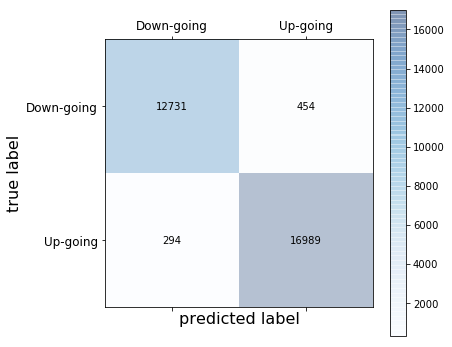

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
	for j in range(confmat.shape[1]):
		ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label',size=16)
plt.ylabel('true label',size=16)
ax.set_xticklabels([''] + ["Down-going", "Up-going"], size=12)
ax.set_yticklabels([''] + ["Down-going", "Up-going"], size=12)
fig.colorbar(cax)
plt.show()

In [9]:
confmat = np.asarray([[12673, 512],[553, 16731]])

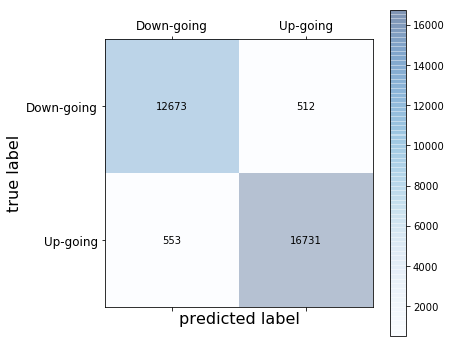

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

fig, ax = plt.subplots(figsize=(6, 6))
cax = ax.matshow(confmat, cmap=plt.cm.Blues, alpha=0.3)
for i in range(confmat.shape[0]):
	for j in range(confmat.shape[1]):
		ax.text(x=j, y=i, s=confmat[i, j], va='center', ha='center')
plt.xlabel('predicted label',size=16)
plt.ylabel('true label',size=16)
ax.set_xticklabels([''] + ["Down-going", "Up-going"], size=12)
ax.set_yticklabels([''] + ["Down-going", "Up-going"], size=12)
fig.colorbar(cax)
plt.show()